## Install Plot Library

In [3]:
!pip install seaborn matplotlib

## Extract Data

1. We collected outputs from various algorithms, downloaded, and unzipped them in `experiment.ipynb`. 
2. Now, we need to extract the data from the output directory and store it in lists.


In [8]:
import os
import pandas as pd

# Directory containing the output files
output_dir = "output"

csr_data = []
multi_pred_data = []
lstm_data = []
iaso_data = []
patchTST_data = []
gpt_data = []
stats_data = []


# Process files in the output directory
for filename in os.listdir(output_dir):
    if filename.startswith("csr"):
        with open(os.path.join(output_dir, filename), 'r') as file:
            cluster_name = None
            for line in file:
                if line.startswith("Processing"):
                    cluster_info = line.split()
                    if len(cluster_info) >= 3:
                        cluster_name = cluster_info[2]
                elif line.strip():
                    values = line.split(", ")
                    if len(values) == 5:
                        date, cluster, host, disk, prediction = values
                        csr_data.append([date, cluster, host, disk, prediction.strip()])
    elif filename.startswith("multi_pred"):
        with open(os.path.join(output_dir, filename), 'r') as file:
            for line in file:
                if line.strip():
                    values = line.split(", ")
                    if len(values) == 5:
                        date, cluster, host, disk, prediction = values
                        multi_pred_data.append([date, cluster, host, disk, prediction.strip()])
    elif filename.startswith("GPT-4"):
        with open(os.path.join(output_dir, filename), 'r') as file:
            for line in file:
                if line.strip():
                    values = line.split(",")
                    if len(values) == 5:
                        date, cluster, host, disk, prediction = values
                        gpt_data.append([date, cluster, host, disk, prediction.strip()])
    elif filename.startswith("lstm"):
        with open(os.path.join(output_dir, filename), 'r') as file:
            for line in file:
                if line.strip():
                    values = line.split(", ")
                    if len(values) == 6:
                        date, cluster, host, disk, mse, prediction = values
                        lstm_data.append([date, cluster, host, disk, prediction.strip()])
    elif filename.startswith("patchTST"):
        with open(os.path.join(output_dir, filename), 'r') as file:
            for line in file:
                if line.strip():
                    values = line.split(", ")
                    if len(values) == 6:
                        date, cluster, host, disk, mse, prediction = values
                        patchTST_data.append([date, cluster, host, disk, prediction.strip()])

## Convert DataFrame

1. Load prediction data into DataFrames.
2. Filter data based on lookback days and threshold.
   - **Lookback days**: Consider data from the last `n` days for each cluster.
   - **Threshold**: Mark a disk as faulty if it is alerted more than the specified threshold percentage.
3. Aggregate predictions and compare them with actual faults.
4. Compute the following metrics:
   - **True Positives (TP)**
   - **False Positives (FP)**
   - **True Negatives (TN)**
   - **False Negatives (FN)**
   - **Precision**
   - **Recall**
5. Evaluate prediction models (e.g., CSR, multi_pred, LSTM, GPT, PatchTST) for various lookback days and thresholds.


In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

columns = ["Date", "Cluster", "Host", "Disk", "Prediction"]

df_csr = pd.DataFrame(csr_data, columns=columns)
df_multi_pred = pd.DataFrame(multi_pred_data, columns=columns)
df_lstm = pd.DataFrame(lstm_data, columns=columns)
df_gpt = pd.DataFrame(gpt_data, columns=columns)
df_patchTST = pd.DataFrame(patchTST_data, columns=columns)

df_csr['Prediction'] = df_csr['Prediction'].map({'T': True, 'F': False})
df_multi_pred['Prediction'] = df_multi_pred['Prediction'].map({'T': True, 'F': False})
df_lstm['Prediction'] = df_lstm['Prediction'].map({'T': True, 'F': False})
df_gpt['Prediction'] = df_gpt['Prediction'].map({'T': True, 'F': False})
df_patchTST['Prediction'] = df_patchTST['Prediction'].map({'T': True, 'F': False})

def evaluate_cluster(cluster, cluster_df, err_df, lookback_days, threshold, score_column='Prediction'):
    cluster_df['Date'] = pd.to_datetime(cluster_df['Date'])
    last_date = cluster_df['Date'].max()
    lookback_date = last_date - pd.Timedelta(days=lookback_days)
    filtered_df = cluster_df[cluster_df['Date'] >= lookback_date]
    
    if score_column == 'Score':
        predicted_disks = filtered_df.groupby(['Cluster', 'Host', 'Disk'])[score_column].sum() > threshold
    else:
        predicted_disks = filtered_df.groupby(['Cluster', 'Host', 'Disk'])[score_column].mean() >= threshold
        
    predicted_disks = predicted_disks.reset_index()
    predicted_disks.columns = ['Cluster', 'Host', 'Disk', 'Predicted_Faulty']
    
    err_disks = set(zip(err_df['cluster'], err_df['host_name'], err_df['disk_id']))
    predicted_disks['Actual_Faulty'] = predicted_disks.apply(
        lambda row: (row['Cluster'], row['Host'], row['Disk']) in err_disks,
        axis=1
    )
    
    TP = ((predicted_disks['Predicted_Faulty'] == True) & (predicted_disks['Actual_Faulty'] == True)).sum()
    FP = ((predicted_disks['Predicted_Faulty'] == True) & (predicted_disks['Actual_Faulty'] == False)).sum()
    TN = ((predicted_disks['Predicted_Faulty'] == False) & (predicted_disks['Actual_Faulty'] == False)).sum()
    FN = ((predicted_disks['Predicted_Faulty'] == False) & (predicted_disks['Actual_Faulty'] == True)).sum()
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return {
        'Cluster': cluster,
        'Lookback_Days': lookback_days,
        'Threshold': threshold,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Precision': precision,
        'Recall': recall
    }

perseus_dir = "./data"
err_df = pd.read_csv("./index/slow_drive_info.csv")

lookback_days_list = [1, 3, 5, 7, 10, 15]
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

results_csr = []
results_multipred = []
results_lstm = []
results_gpt = []
results_patchTST = []

def evaluate_and_store_results(dataframe, results_list):
    for cluster, cluster_df in dataframe.groupby('Cluster'):
        for lookback_days in lookback_days_list:
            for threshold in threshold_list:
                result = evaluate_cluster(cluster, cluster_df, err_df, lookback_days, threshold)
                results_list.append(result)

evaluate_and_store_results(df_csr, results_csr)
evaluate_and_store_results(df_multi_pred, results_multipred)
evaluate_and_store_results(df_lstm, results_lstm)
evaluate_and_store_results(df_gpt, results_gpt)
evaluate_and_store_results(df_patchTST, results_patchTST)

df_results_csr = pd.DataFrame(results_csr)
df_results_multipred = pd.DataFrame(results_multipred)
df_results_lstm = pd.DataFrame(results_lstm)
df_results_gpt = pd.DataFrame(results_gpt)
df_results_patchTST = pd.DataFrame(results_patchTST)

print("CSR Results:")
print(df_results_csr.head())

print("\nMulti-Pred Results:")
print(df_results_multipred.head())

print("\nLSTM Results:")
print(df_results_lstm.head())

print("\nGPT Results:")
print(df_results_gpt.head())

print("\nPatchTST Results:")
print(df_results_patchTST.head())


CSR Results:
     Cluster  Lookback_Days  Threshold  TP  FP   TN  FN  Precision  Recall
0  cluster_A              1        0.1   2  26  332   0   0.071429     1.0
1  cluster_A              1        0.2   2  26  332   0   0.071429     1.0
2  cluster_A              1        0.3   2  26  332   0   0.071429     1.0
3  cluster_A              1        0.4   2  26  332   0   0.071429     1.0
4  cluster_A              1        0.5   2  26  332   0   0.071429     1.0

Multi-Pred Results:
     Cluster  Lookback_Days  Threshold  TP  FP   TN  FN  Precision  Recall
0  cluster_A              1        0.1   2   2  356   0        0.5     1.0
1  cluster_A              1        0.2   2   2  356   0        0.5     1.0
2  cluster_A              1        0.3   2   2  356   0        0.5     1.0
3  cluster_A              1        0.4   2   2  356   0        0.5     1.0
4  cluster_A              1        0.5   2   2  356   0        0.5     1.0

LSTM Results:
     Cluster  Lookback_Days  Threshold  TP  FP   TN

## Heatmap Plotting for Model Evaluation

1. Create heatmaps to visualize the precision and recall metrics of various prediction models. 
 - These heatmaps are based on different lookback days and thresholds. 
 - A custom colormap is utilized to enhance the visual representation, highlighting the performance of different algorithms across various clusters for benchmarking purposes.


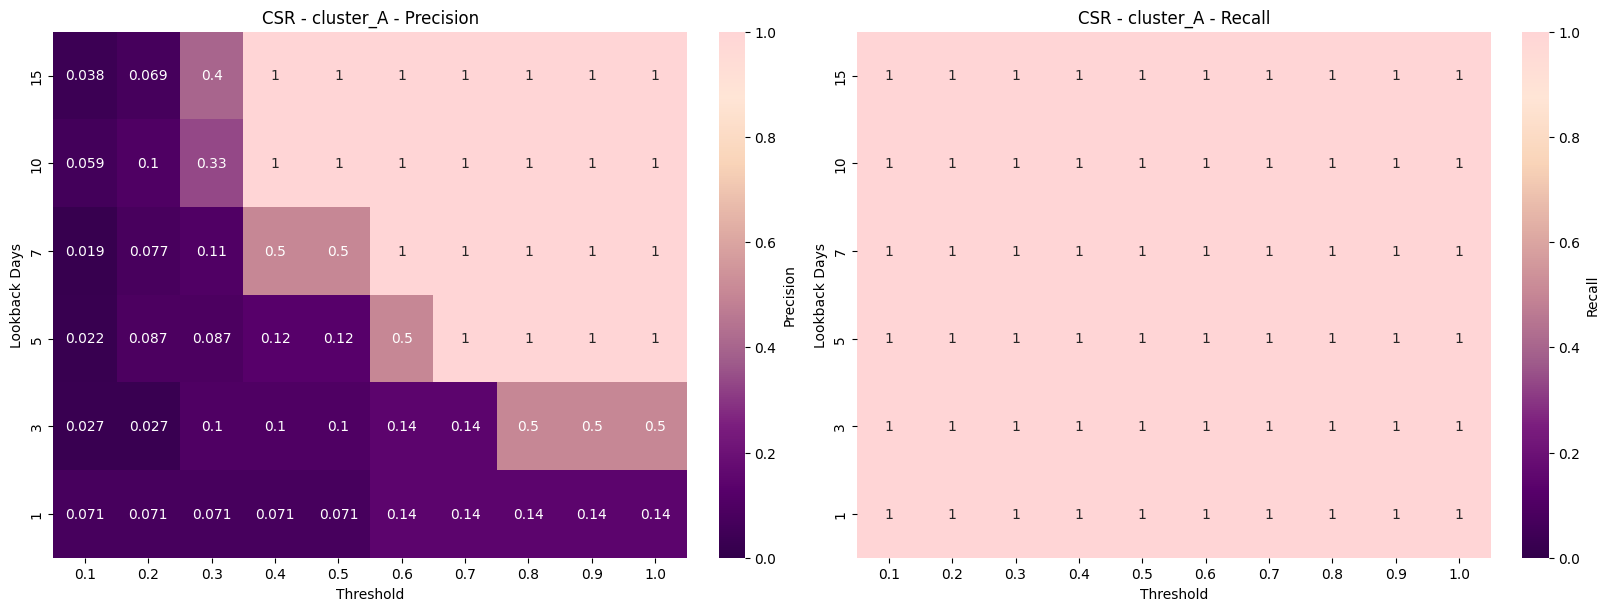

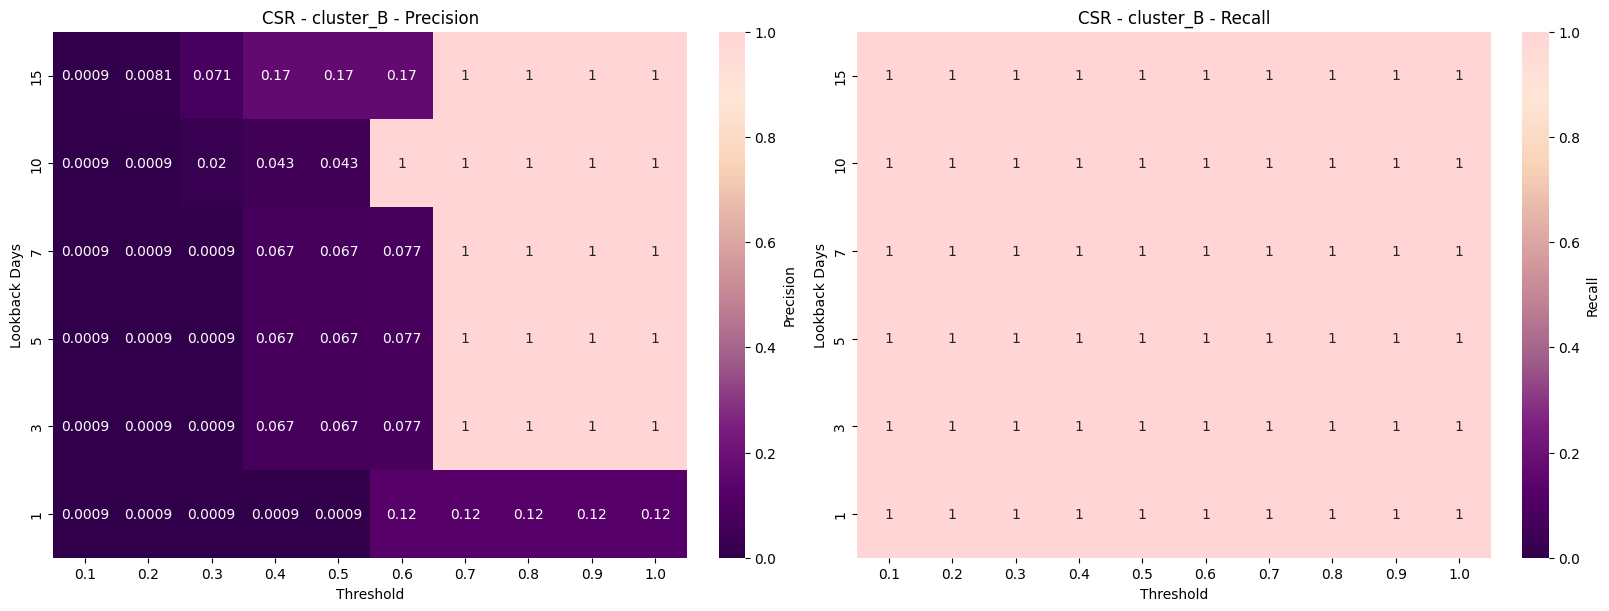

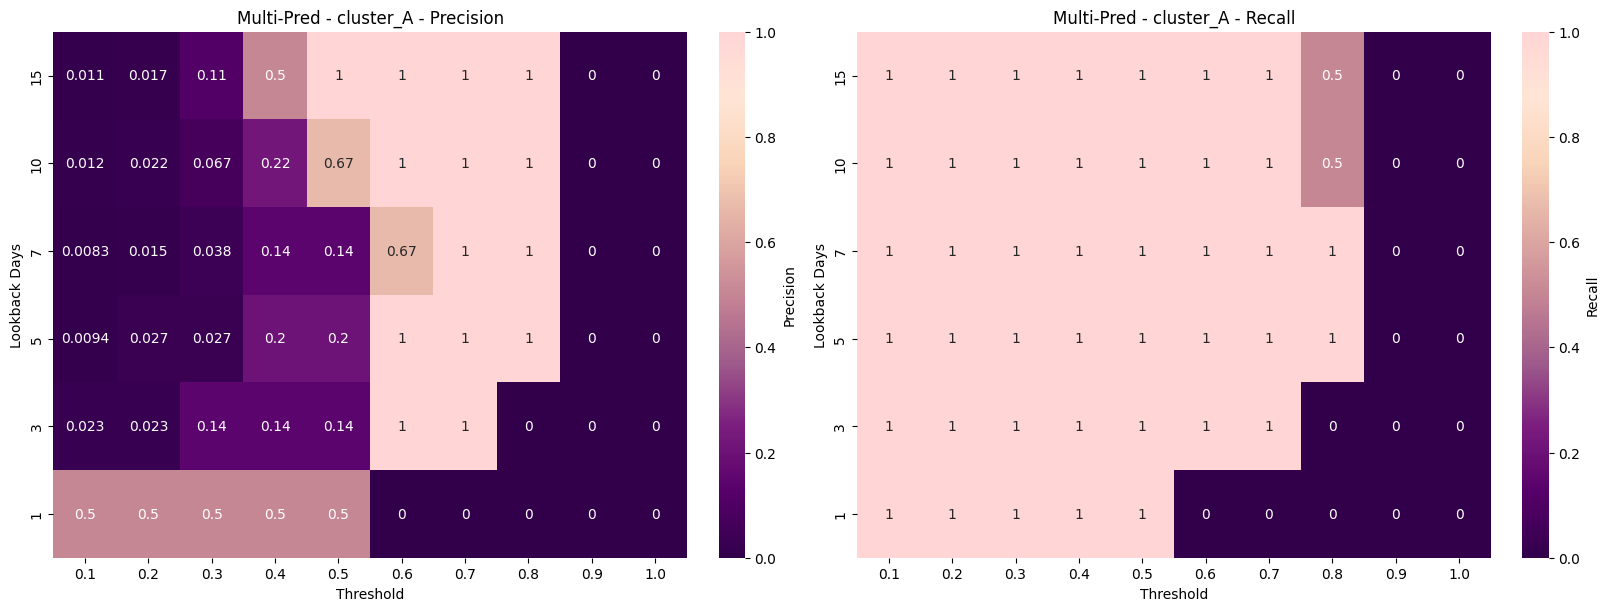

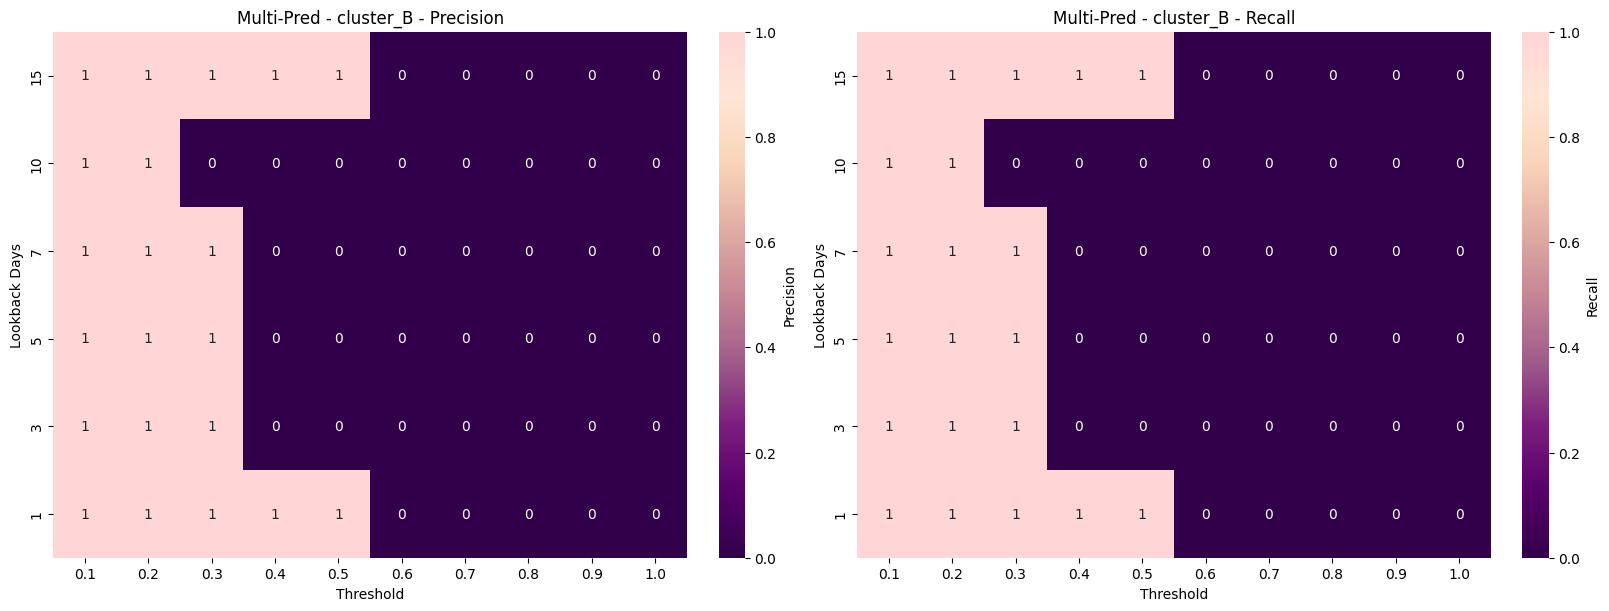

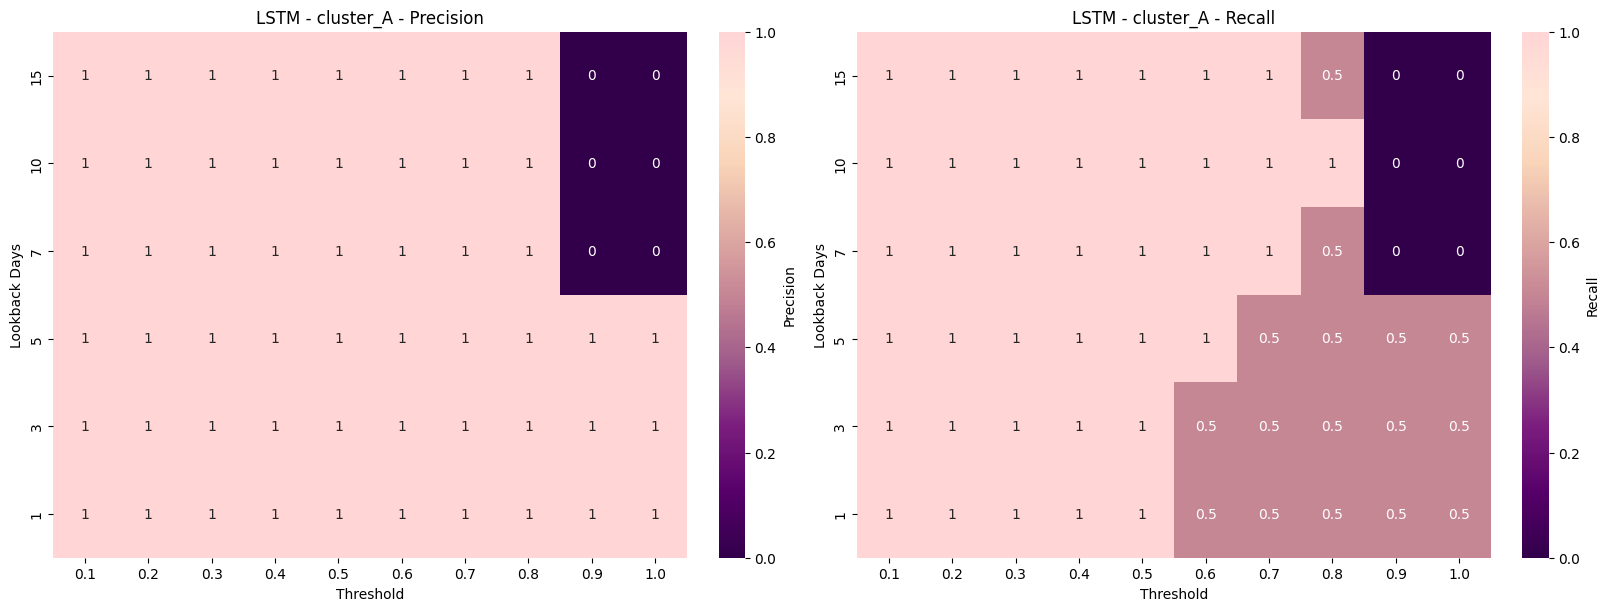

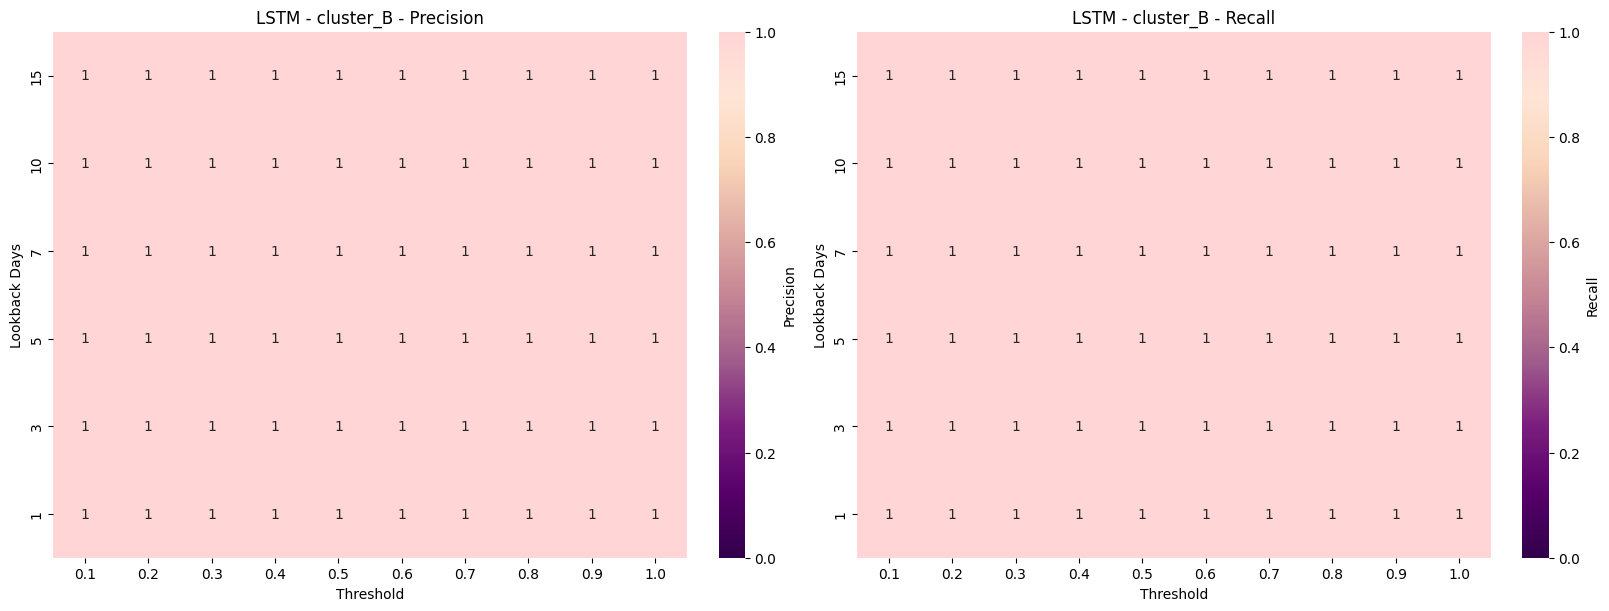

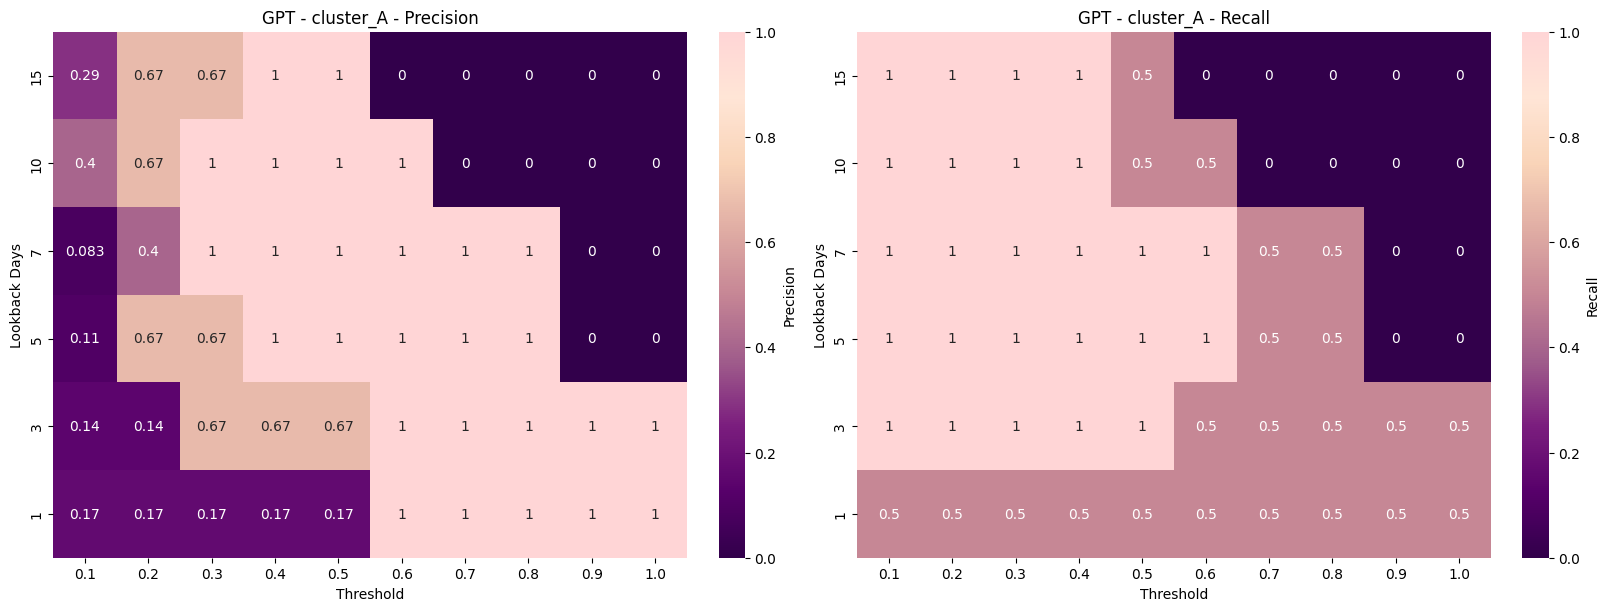

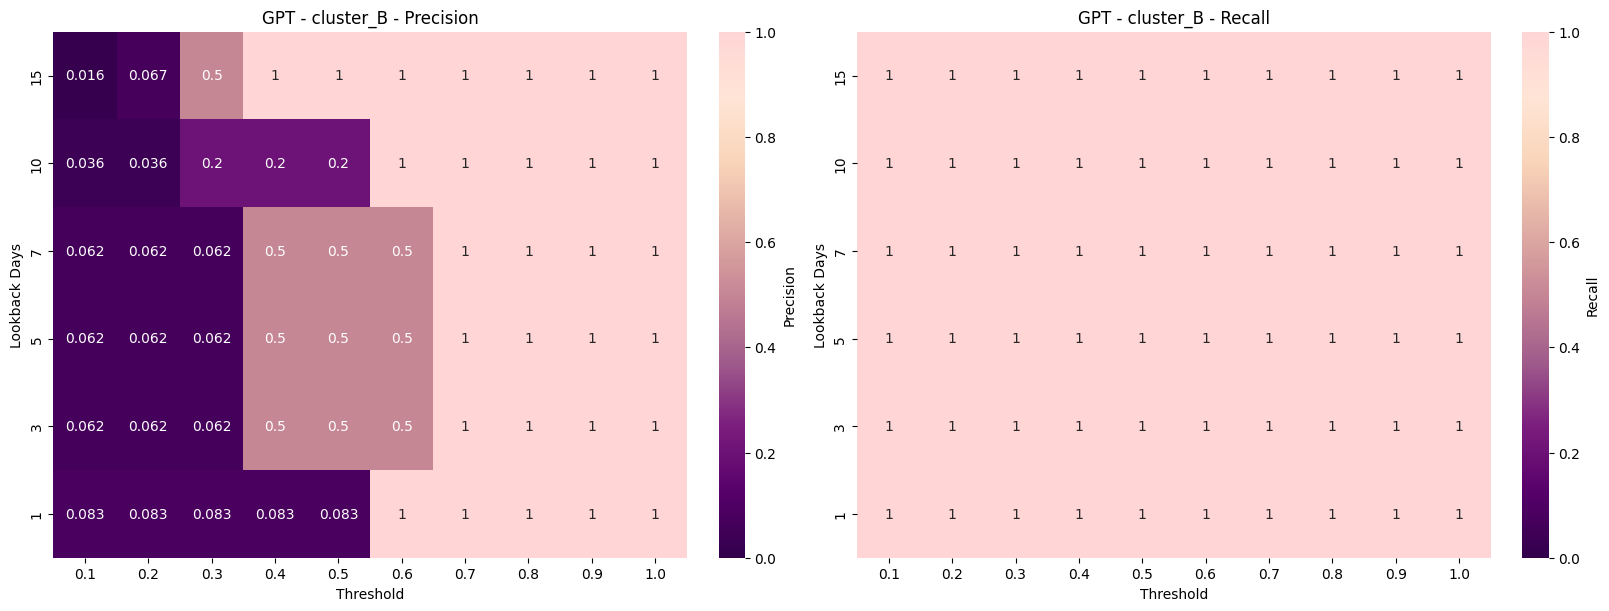

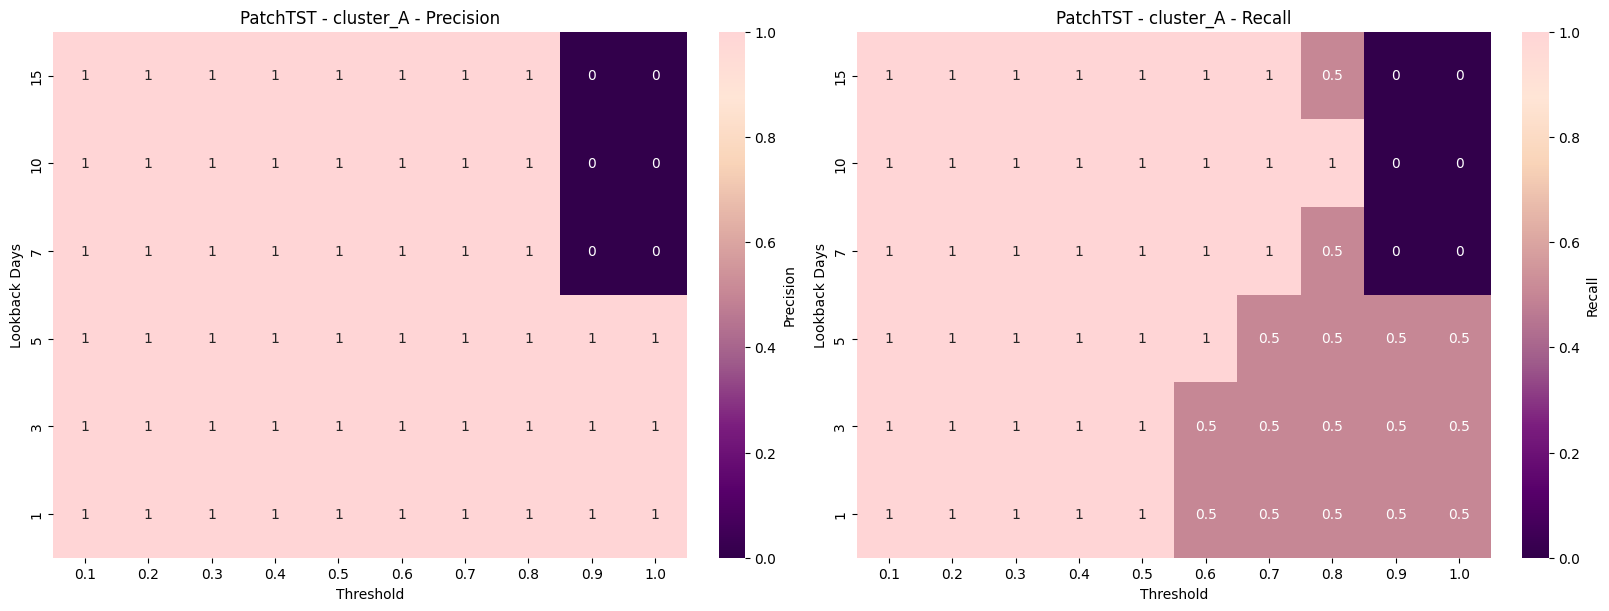

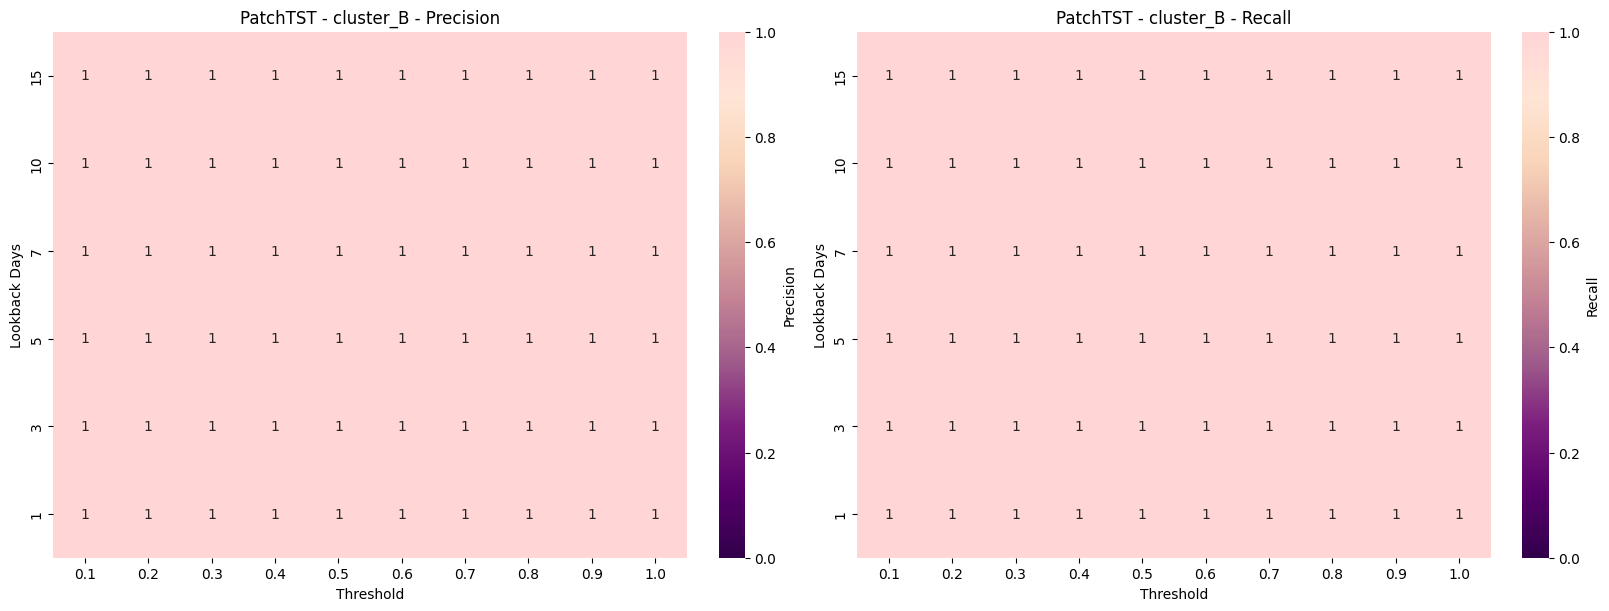

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap
colors = ["#32004b", "#57006a", "#7b1e7e", "#a05d8b", "#c68695", "#e0ada4", "#f9d4b8", "#ffe5d6", "#ffd5d6"]
cmap = LinearSegmentedColormap.from_list("custom_heatmap", colors)

# Function to plot heatmaps for a given DataFrame
def plot_heatmaps(df, title_prefix):
    clusters = df['Cluster'].unique()
    for cluster in clusters:
        cluster_data = df[df['Cluster'] == cluster]
        
        precision_data = cluster_data.pivot_table(values='Precision', index='Lookback_Days', columns='Threshold')
        recall_data = cluster_data.pivot_table(values='Recall', index='Lookback_Days', columns='Threshold')
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
        
        sns.heatmap(precision_data, ax=axs[0], annot=True, cmap=cmap, vmin=0, vmax=1, cbar_kws={'label': 'Precision'})
        axs[0].set_title(f'{title_prefix} - {cluster} - Precision')
        axs[0].set_xlabel('Threshold')
        axs[0].set_ylabel('Lookback Days')
        axs[0].invert_yaxis()
        
        sns.heatmap(recall_data, ax=axs[1], annot=True, cmap=cmap, vmin=0, vmax=1, cbar_kws={'label': 'Recall'})
        axs[1].set_title(f'{title_prefix} - {cluster} - Recall')
        axs[1].set_xlabel('Threshold')
        axs[1].set_ylabel('Lookback Days')
        axs[1].invert_yaxis()
        
        plt.show()

plot_heatmaps(df_results_csr, "CSR")
plot_heatmaps(df_results_multipred, "Multi-Pred")
plot_heatmaps(df_results_lstm, "LSTM")
plot_heatmaps(df_results_gpt, "GPT")
plot_heatmaps(df_results_patchTST, "PatchTST")